In [1]:
import glob
import sys

import corner
import jax
import numpy as np
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.MALA import MALA
import arviz as az
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from matplotlib import pyplot as plt
from numpyro import distributions as dist

sys.path.append("gwkokab")

from gwkokab.inference.model_test import *
from gwkokab.utils import get_key

/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
[Loading lalsimutils.py : MonteCarloMarginalization version]
  

In [2]:
posterior_regex = "ecc_events/event_*.dat"
true_values = np.loadtxt("syn_data/realization_0/configuration.dat")
posteriors = glob.glob(posterior_regex)
data_set = {i: np.loadtxt(event)[:, 0:2] for i, event in enumerate(posteriors)}

In [ ]:
data = data_set[0]
indexes = [0, data_set[0].shape[0]]
for i in range(1, len(data_set.keys())):
    data = jnp.concatenate((data, data_set[i]))
    indexes.append(indexes[-1] + data_set[i].shape[0])
indexes = jnp.asarray(indexes)

In [3]:
n_chains = 20
n_dim = 4

In [4]:
alpha_prior_dist = dist.Uniform(-5.0, 5.0)
mmin_prior_dist = dist.Uniform(1.0, 20.0)
mmax_prior_dist = dist.Uniform(30.0, 100.0)
rate_prior_dist = dist.Uniform(1, 500)

alpha_prior = alpha_prior_dist.sample(get_key(), (n_chains,))
mmin_prior = mmin_prior_dist.sample(get_key(), (n_chains,))
mmax_prior = mmax_prior_dist.sample(get_key(), (n_chains,))
rate_prior = rate_prior_dist.sample(get_key(), (n_chains,))

initial_position = jnp.column_stack([alpha_prior, mmin_prior, mmax_prior, rate_prior])

In [5]:
n_layers = 4
hidden_size = [128, 128]
num_bins = 8

In [6]:
model = MaskedCouplingRQSpline(n_dim, n_layers, hidden_size, num_bins, get_key())

In [7]:
step_size = 1e-1
MALA_Sampler = MALA(log_inhomogeneous_poisson_likelihood, True, {"step_size": step_size})


n_loop_training = 100
n_loop_production = 100
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

rng_key_set = initialize_rng_keys(n_chains, seed=42)

In [8]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

nf_sampler.sample(
    initial_position,
    data={
        "data": data_set,
    },
)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Compiling MALA body


2024-03-09 04:55:42.831099: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-03-09 04:55:53.334686: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m10.503353709s

********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Tuning global sampler:  14%|█▍        | 7/50 [09:30<58:25, 81.51s/it]   


KeyboardInterrupt: 

In [ ]:
out_train = nf_sampler.get_sampler_state(training=True)
print("Logged during tuning:", out_train.keys())

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [ ]:
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
nf_samples = np.array(nf_sampler.sample_flow(10000))

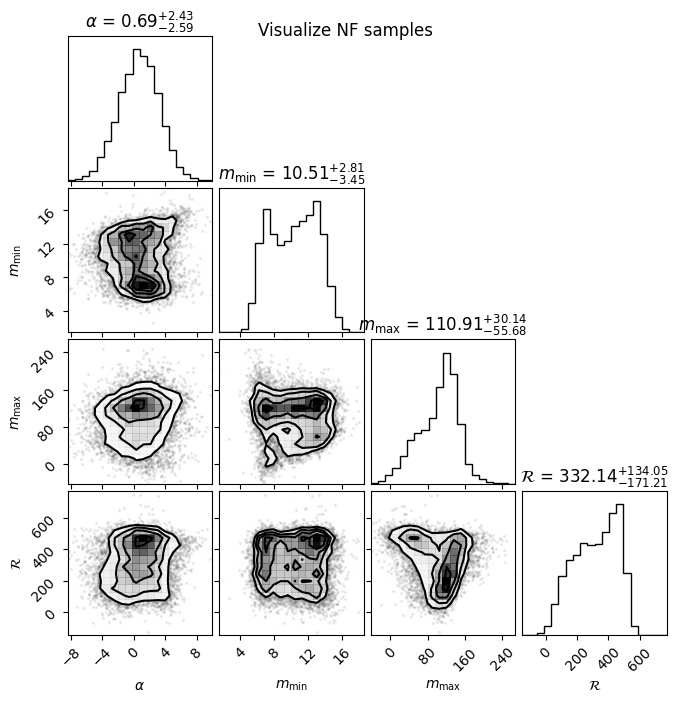

In [ ]:
labels = [r"$\alpha$", r"$m_{\text{min}}$", r"$m_{\text{max}}$", r"$\mathcal{R}$"]

# Plot Nf samples
figure = corner.corner(
    nf_samples,
    labels=labels,
    show_titles=True,
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()
figure.savefig("nf_samples.png")

Text(0.5, 0, 'Iteration')

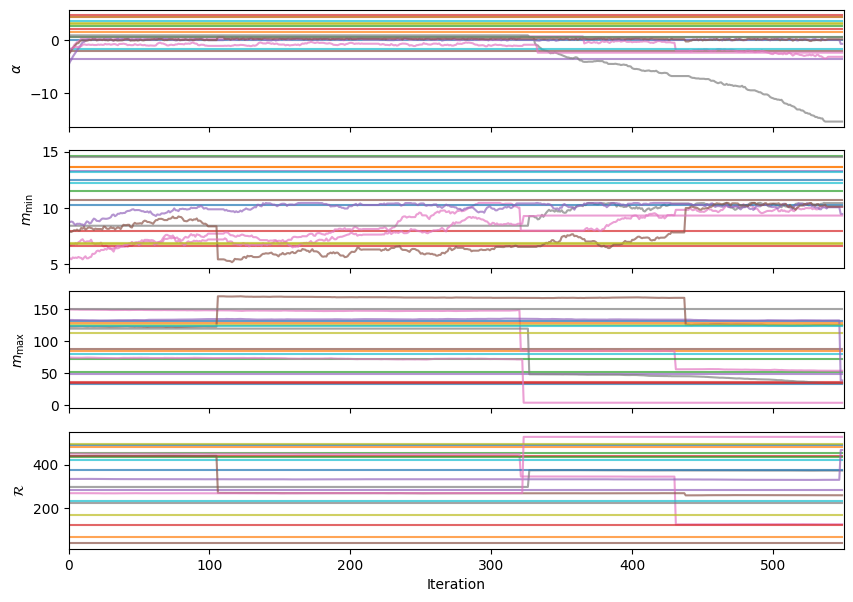

In [ ]:
fig, axes = plt.subplots(n_dim, 1, figsize=(10, 7), sharex=True)
for i in range(n_chains):
    axes[0].plot(chains[i, :, 0], alpha=0.7)
    axes[1].plot(chains[i, :, 1], alpha=0.7)
    axes[2].plot(chains[i, :, 2], alpha=0.7)
    axes[3].plot(chains[i, :, 3], alpha=0.7)
    axes[0].set_xlim(0, chains.shape[1])
    axes[1].set_xlim(0, chains.shape[1])
    axes[2].set_xlim(0, chains.shape[1])
    axes[3].set_xlim(0, chains.shape[1])
    axes[0].set_ylabel(labels[0])
    axes[1].set_ylabel(labels[1])
    axes[2].set_ylabel(labels[2])
    axes[3].set_ylabel(labels[3])
axes[-1].set_xlabel("Iteration")

fig.savefig("chains.png")

In [ ]:
# To convert notebook to script
# jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb